# Template code for CNN

In this notebook, we will show a simple usage of CNN on the MNIST dataset. 
The usage of GPUs is highly recommended

In [2]:
#!pip install torch==2.4 # Run just once
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim
from math import floor

# Set torch seed


#  Q1

In [3]:
manual_seed = 42
torch.manual_seed(manual_seed)

In [4]:
torch.randint(1, 10 , (1,1))

tensor([[7]])

se runno di fila le due celle ottengo tensor([[7]]) se runni due volte la seconda tensor([[6]])

# Q2


In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0, 0, 0), (1, 1, 1))])

batch_size = 32

dataset_train = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
dataset_test = datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

trainloader = DataLoader(dataset_train, batch_size=batch_size,shuffle=True, num_workers=2)
#testloader = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False, num_workers=2)
testloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=2)



classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


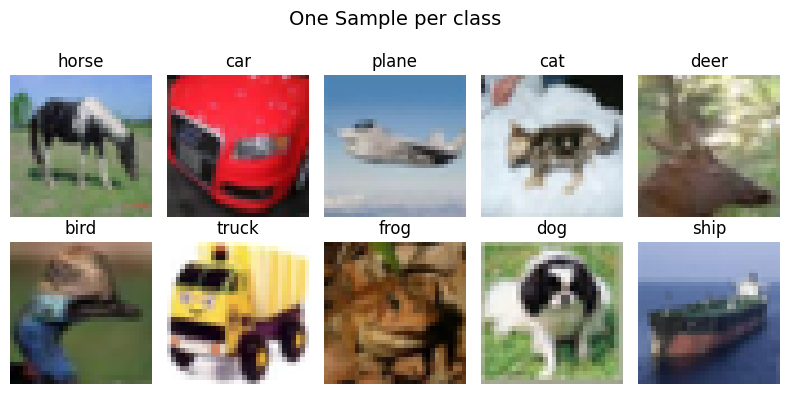

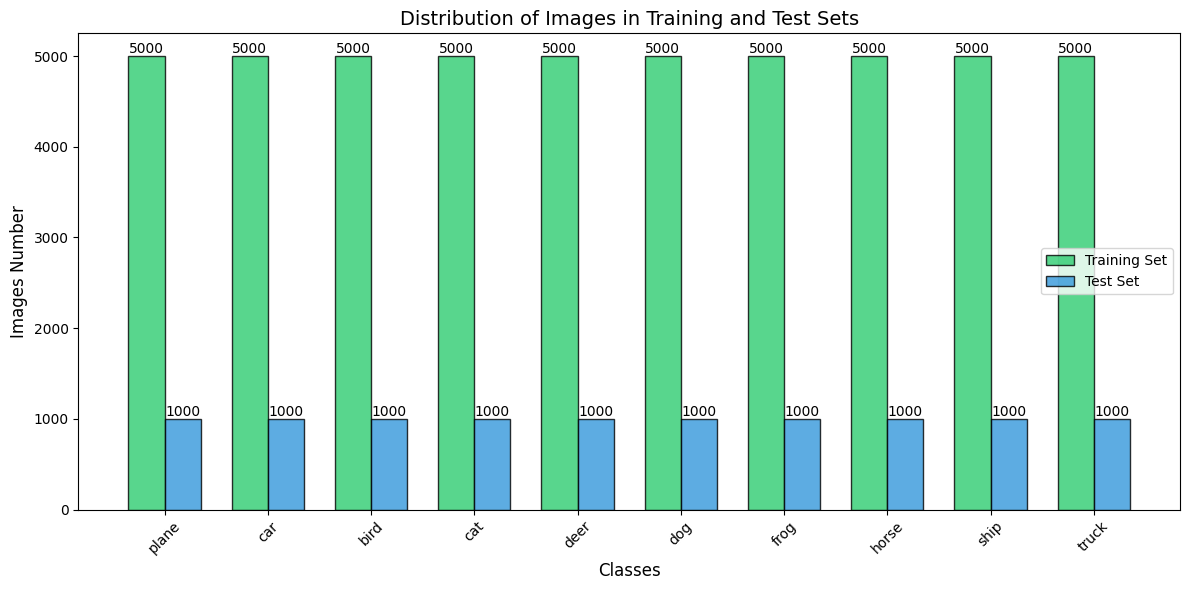

In [6]:
# Funzione per mostrare immagini senza normalizzazione
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(15, 15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Carica immagini di esempio
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Mostra una sola immagine per classe senza normalizzazione
plt.figure(figsize=(8, 4))
class_samples = {}
for img, label in zip(images, labels):
    label_name = classes[label]
    if label_name not in class_samples and len(class_samples) < 10:
        class_samples[label_name] = img

for idx, (class_name, img) in enumerate(class_samples.items(), 1):
    plt.subplot(2, 5, idx)
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.title(f'{class_name}')
    plt.axis('off')
plt.suptitle('One Sample per class', fontsize=14, y=1.0)
plt.tight_layout()
plt.show()

# Conta le istanze nel training set e test set
train_dist = [0] * len(classes)
test_dist = [0] * len(classes)

for data, labels in trainloader:
    for label in labels:
        train_dist[label.item()] += 1

for data, labels in testloader:
    for label in labels:
        test_dist[label.item()] += 1

# Grafico della distribuzione
plt.figure(figsize=(12, 6))
x = np.arange(len(classes))
width = 0.35
plt.bar(x - width / 2, train_dist, width, label='Training Set', color='#2ecc71', alpha=0.8, edgecolor='black')
plt.bar(x + width / 2, test_dist, width, label='Test Set', color='#3498db', alpha=0.8, edgecolor='black')
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Images Number', fontsize=12)
plt.title('Distribution of Images in Training and Test Sets', fontsize=14)
plt.xticks(x, classes, rotation=45)
plt.legend()

# Aggiungi etichette sulle barre
for i in range(len(x)):
    plt.text(x[i] - width / 2, train_dist[i], str(train_dist[i]), ha='center', va='bottom')
    plt.text(x[i] + width / 2, test_dist[i], str(test_dist[i]), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Q3

i. The type is normally PIL.Image
ii. to convert in a suitable type we have to do this toTensor()


In [6]:
print(f"Image shape: {images[0].shape}")
print(f"Label: {labels[0]}")

Image shape: torch.Size([3, 32, 32])
Label: 7


iii. the dimension should be (3,3,32)

iv. the meaning are > Cin = 3 are numbers of channels, 32 = Height, 32=Width

# Q4

Same as before


# Q5

In [ ]:
dataset_validation, dataset_test = torch.utils.data.random_split(dataset_test, [0.5, 0.5])
validloader = DataLoader(dataset_validation, batch_size=batch_size)
testloader = DataLoader(dataset_test, batch_size=batch_size)

num_steps_per_epoch = len(trainloader)
print(f"Numero di step per epoca: {num_steps_per_epoch}")
a = len(validloader)
print(f"Numero di step per epoca: {a}")



Numero di step per epoca: 1563
Numero di step per epoca: 157


# Q6

In [8]:
import torch.nn as nn
import torch.nn.functional as F
from math import floor

def out_dimensions(conv_layer, h_in, w_in):
    """Calculate output dimensions after convolution"""
    h_out = floor((h_in + 2 * conv_layer.padding[0] - 
                   conv_layer.dilation[0] * (conv_layer.kernel_size[0] - 1) - 1) / 
                   conv_layer.stride[0] + 1)
    w_out = floor((w_in + 2 * conv_layer.padding[1] - 
                   conv_layer.dilation[1] * (conv_layer.kernel_size[1] - 1) - 1) / 
                   conv_layer.stride[1] + 1)
    return h_out, w_out

class CCNSuperSayan(nn.Module):
    def __init__(self):
        super(CCNSuperSayan, self).__init__()
        
        # First convolutional block: Conv - Conv - Activ - Pool
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=0, stride=1)
        h_out, w_out = out_dimensions(self.conv1, 32, 32)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, stride=1)
        h_out, w_out = out_dimensions(self.conv2, h_out, w_out)
        
        self.pool1 = nn.MaxPool2d(2, 2)
        h_out, w_out = int(h_out/2), int(w_out/2)
        
        # Second convolutional block: Conv - Conv - Activ - Pool
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, stride=1)
        h_out, w_out = out_dimensions(self.conv3, h_out, w_out)
        
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=0, stride=1)
        h_out, w_out = out_dimensions(self.conv4, h_out, w_out)
        
        self.pool2 = nn.MaxPool2d(2, 2)
        h_out, w_out = int(h_out/2), int(w_out/2)
        # Fully connected layers
        self.fc1 = nn.Linear(64 * h_out * w_out, 128)
        self.fc2 = nn.Linear(128, 10)
        
        # Store final dimensions for reshape in forward pass
        self.dimensions_final = (64, h_out, w_out)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool2(x)

        n_channels, h, w = self.dimensions_final
        x = x.view(-1, n_channels * h * w)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
   


# Q7

In [9]:
model = CCNSuperSayan() # CNN()
learning_rate = 0.032
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' 
    if torch.backends.mps.is_available() else 'cpu')
model = model.to(DEVICE)
print("Working on", DEVICE)


Working on mps


In [10]:
n_epochs = 4
n_step_train = 100  
n_steps_valid = 50 
train_loss_list = []
validation_loss_list = []
train_accuracy_list = []
validation_accuracy_list = []

for epoch in range(n_epochs):
    loss_train = 0
    correct_train = 0
    total_train = 0
    
    for step, (data, target) in enumerate(trainloader, 1):
        # Set the model in training mode
        model.train()
        data, target = data.to(DEVICE), target.to(DEVICE)
        
        # Set the gradient to 0
        optimizer.zero_grad()
        
        # Make a prediction
        output = model(data)
        
        # Compute the loss function
        loss = loss_fn(output, target)
        loss_train += loss.item()
        
        # Backpropagation
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Calculate training accuracy
        _, predicted = torch.max(output.data, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()
        
        # Record and print stats every n_steps
        if step % n_step_train == 0:
            avg_train_loss = loss_train / step
            train_accuracy = 100 * correct_train / total_train
            print(f"Epoch {epoch + 1}, Step {step}: Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
            if step == 1500:
                train_loss_list.append(avg_train_loss)
                train_accuracy_list.append(train_accuracy)
            
    # Validation loss and accuracy at the end of each epoch
    model.eval()
    loss_valid = 0
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for step, (data, target) in enumerate(validloader, 1):
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            loss = loss_fn(output, target)
            loss_valid += loss.item()
            
            # Calculate validation accuracy
            _, predicted = torch.max(output.data, 1)
            total_valid += target.size(0)
            correct_valid += (predicted == target).sum().item()
            
            # Record and print stats every n_steps
            if step % n_steps_valid == 0:
                avg_valid_loss = loss_valid / step
                valid_accuracy = 100 * correct_valid / total_valid
                print(f"Epoch {epoch + 1}, Step {step}: Validation Loss: {avg_valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.2f}%")
                if step == 150:
                    validation_loss_list.append(avg_valid_loss)
                    validation_accuracy_list.append(valid_accuracy)



Epoch 1, Step 100: Train Loss: 2.3030, Train Accuracy: 10.34%
Epoch 1, Step 200: Train Loss: 2.3011, Train Accuracy: 10.72%
Epoch 1, Step 300: Train Loss: 2.2878, Train Accuracy: 12.62%
Epoch 1, Step 400: Train Loss: 2.2528, Train Accuracy: 14.76%
Epoch 1, Step 500: Train Loss: 2.2126, Train Accuracy: 16.91%
Epoch 1, Step 600: Train Loss: 2.1822, Train Accuracy: 18.34%
Epoch 1, Step 700: Train Loss: 2.1576, Train Accuracy: 19.72%
Epoch 1, Step 800: Train Loss: 2.1305, Train Accuracy: 21.07%
Epoch 1, Step 900: Train Loss: 2.1040, Train Accuracy: 22.26%
Epoch 1, Step 1000: Train Loss: 2.0729, Train Accuracy: 23.62%
Epoch 1, Step 1100: Train Loss: 2.0432, Train Accuracy: 24.79%
Epoch 1, Step 1200: Train Loss: 2.0132, Train Accuracy: 25.98%
Epoch 1, Step 1300: Train Loss: 1.9869, Train Accuracy: 27.06%
Epoch 1, Step 1400: Train Loss: 1.9595, Train Accuracy: 28.16%
Epoch 1, Step 1500: Train Loss: 1.9332, Train Accuracy: 29.11%
Epoch 1, Step 50: Validation Loss: 1.5257, Validation Accuracy: 

In [11]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for data, target in testloader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += target.size(0)
        n_correct += (predicted == target).sum().item()

    acc = 100.0 * n_correct / n_samples
print("Accuracy on the test set:", acc, "%")

Accuracy on the test set: 67.32 %


# Q8

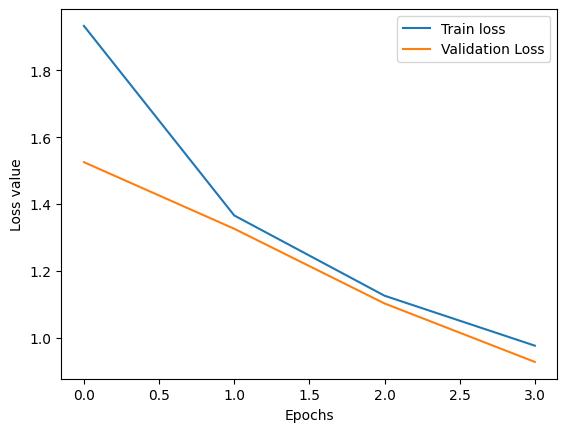

In [12]:
plt.figure()
plt.plot(range(n_epochs), train_loss_list)
plt.plot(range(n_epochs), validation_loss_list)
plt.legend(["Train loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.show()

# Q9

In [13]:
class CCNSuperSayanGod(nn.Module):
    def __init__(self):
        super(CCNSuperSayanGod, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        h_out, w_out = out_dimensions(self.conv1, 32, 32)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(64)
        h_out, w_out = out_dimensions(self.conv2, h_out, w_out)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.2)  # Aggiunto dropout dopo il primo blocco
        h_out, w_out = int(h_out / 2), int(w_out / 2)

        # Second convolutional block
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(128)
        h_out, w_out = out_dimensions(self.conv3, h_out, w_out)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, stride=1)
        self.bn4 = nn.BatchNorm2d(128)
        h_out, w_out = out_dimensions(self.conv4, h_out, w_out)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.2)  # Aggiunto dropout dopo il secondo blocco
        h_out, w_out = int(h_out / 2), int(w_out / 2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * h_out * w_out, 512)  # Aumentato a 512
        self.bn5 = nn.BatchNorm1d(512)
        self.dropout3 = nn.Dropout(0.4)  # Aumentato dropout
        
        self.fc2 = nn.Linear(512, 128)  # Aumentato a 128
        self.bn6 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(0.4)  # Aumentato dropout
        
        self.fc3 = nn.Linear(128, 10)

        # Store final dimensions for reshape
        self.dimensions_final = (128, h_out, w_out)

    def forward(self, x):
        # First block
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.gelu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.gelu(x)
        x = self.pool1(x)
        x = self.dropout1(x)  # Aggiunto dropout

        # Second block
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.gelu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.gelu(x)
        x = self.pool2(x)
        x = self.dropout2(x)  # Aggiunto dropout

        # Flatten and FC layers
        n_channels, h, w = self.dimensions_final
        x = x.view(-1, n_channels * h * w)

        x = self.fc1(x)
        x = self.bn5(x)
        x = F.gelu(x)
        x = self.dropout3(x)

        x = self.fc2(x)
        x = self.bn6(x)
        x = F.gelu(x)
        x = self.dropout4(x)

        x = self.fc3(x)
        return x

In [14]:
model = CCNSuperSayanGod()
learning_rate = 0.031
optimizer = optim.SGD(model.parameters(), lr=learning_rate,  weight_decay=1e-4) 
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
loss_fn = nn.CrossEntropyLoss()



In [15]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' 
    if torch.backends.mps.is_available() else 'cpu')
model = model.to(DEVICE)
print("Working on", DEVICE)

train_loss_list = []
validation_loss_list = []
n_epochs = 7

for epoch in range(n_epochs):
    loss_train = 0
    for data, target in trainloader:
        # Set the model in training mode
        model.train()
        data, target = data.to(DEVICE), target.to(DEVICE)
        # Set the gradient to 0
        optimizer.zero_grad()
        # Make a prediction
        output = model(data)
        # Compute the loss function
        loss = loss_fn(output, target)
        loss_train += loss.item()
        # Backpropagation
        loss.backward()
        # Update parameters
        optimizer.step()
        
    loss_train = loss_train / len(trainloader) # Consider this alternative method of tracking training loss. 
    train_loss_list.append(loss_train)
    
    # At the end of every epoch, check the validation loss value
    with torch.no_grad():
        model.eval()
        for data, target in validloader: 
            data, target = data.to(DEVICE), target.to(DEVICE)
            # Make a prediction
            output = model(data)
            # Compute the loss function
            validation_loss = loss_fn(output, target).item()
        print(f"Epoch {epoch + 1}: Train loss: {loss_train}, Validation loss {validation_loss}")
        validation_loss_list.append(validation_loss)
        #scheduler.step(validation_loss)



Working on mps
Epoch 1: Train loss: 1.2863245932474703, Validation loss 2.5231363773345947
Epoch 2: Train loss: 0.899636354113876, Validation loss 0.8541802167892456
Epoch 3: Train loss: 0.7577296036771681, Validation loss 0.30649685859680176
Epoch 4: Train loss: 0.6740387789690563, Validation loss 0.11357015371322632
Epoch 5: Train loss: 0.6021780412565495, Validation loss 0.11821608990430832
Epoch 6: Train loss: 0.54459948277176, Validation loss 0.19193199276924133
Epoch 7: Train loss: 0.49789891041629375, Validation loss 0.1569834202528


In [16]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for data, target in testloader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += target.size(0)
        n_correct += (predicted == target).sum().item()

    acc = 100.0 * n_correct / n_samples
print("Accuracy on the test set:", acc, "%")


Accuracy on the test set: 79.76 %


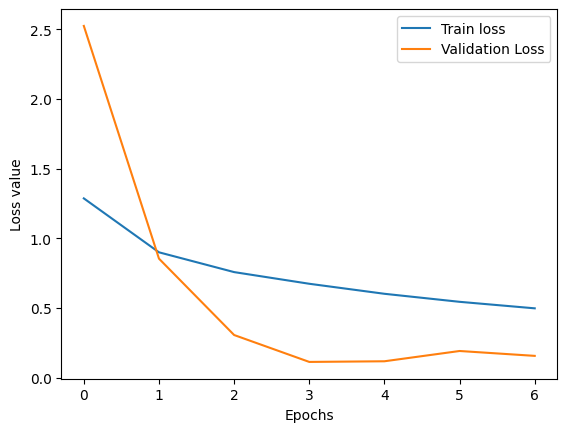

In [17]:
plt.figure()
plt.plot(range(n_epochs), train_loss_list)
plt.plot(range(n_epochs), validation_loss_list)
plt.legend(["Train loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.show()

# Q10

In [18]:

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' 
                     if torch.backends.mps.is_available() else 'cpu')
print("Working on", DEVICE)

test_accuracies = []  # To store test accuracies for each seed

for seed in range(5, 10):
    torch.manual_seed(seed)
    print("\nSeed equal to", torch.random.initial_seed())
    
    # Initialize model and optimizer for each seed
    model = CCNSuperSayan()
    model = model.to(DEVICE)
    learning_rate = 0.032
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    
    # Training loop
    n_epochs = 4
    train_loss_list = []
    validation_loss_list = []
    
    for epoch in range(n_epochs):
        # Training phase
        loss_train = 0
        for data, target in trainloader:
            model.train()
            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss_train += loss.item()
            loss.backward()
            optimizer.step()
            
        loss_train = loss_train / len(trainloader)
        train_loss_list.append(loss_train)
        
        # Validation phase
        with torch.no_grad():
            model.eval()
            for data, target in validloader:  # Just one batch
                data, target = data.to(DEVICE), target.to(DEVICE)
                output = model(data)
                validation_loss = loss_fn(output, target).item()
            print(f"Epoch {epoch + 1}: Train loss: {loss_train:.4f}, "
                    f"Validation loss: {validation_loss:.4f}")
            validation_loss_list.append(validation_loss)
    
    # Evaluate on test set after training
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    test_accuracy = 100 * correct / total
    test_accuracies.append(test_accuracy)
    print(f"Final Test Accuracy for seed {seed}: {test_accuracy:.2f}%")

Working on mps

Seed equal to 5
Epoch 1: Train loss: 1.8788, Validation loss: 1.1653
Epoch 2: Train loss: 1.3826, Validation loss: 1.3794
Epoch 3: Train loss: 1.1515, Validation loss: 0.8709
Epoch 4: Train loss: 0.9977, Validation loss: 0.7845
Final Test Accuracy for seed 5: 65.18%

Seed equal to 6
Epoch 1: Train loss: 1.8888, Validation loss: 1.5124
Epoch 2: Train loss: 1.4092, Validation loss: 1.1601
Epoch 3: Train loss: 1.2139, Validation loss: 1.0198
Epoch 4: Train loss: 1.0736, Validation loss: 1.0372
Final Test Accuracy for seed 6: 60.66%

Seed equal to 7
Epoch 1: Train loss: 1.8731, Validation loss: 1.7068
Epoch 2: Train loss: 1.3711, Validation loss: 0.5917
Epoch 3: Train loss: 1.1570, Validation loss: 1.0724
Epoch 4: Train loss: 1.0042, Validation loss: 0.8890
Final Test Accuracy for seed 7: 61.58%

Seed equal to 8
Epoch 1: Train loss: 1.9134, Validation loss: 1.4501
Epoch 2: Train loss: 1.3847, Validation loss: 1.1053
Epoch 3: Train loss: 1.1488, Validation loss: 0.8782
Epoch